In [104]:
#Librerias necesarias para todo el proyecto
import kaggle
import hashlib
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importamos las librerías necesarias para el modelo de CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from collections import Counter
from tensorflow import keras, config
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

# Importamos las librerías necesarias para el modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
#Aqui almacenaremos los datasets necesarios para los diferentes ejercicios
kaggle.api.authenticate()
# 1. Descargamos el dataset de Fashion MNIST de Zalando
# https://www.kaggle.com/datasets/akrashnoor/brain-tumor
kaggle.api.dataset_download_files("akrashnoor/brain-tumor", path=".", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/akrashnoor/brain-tumor


# 1. EDA

## Labels y Numero de imágenes
Dentro del dataset de imágenes podemos encontrar dos directorios destinados a la clasificación biclase y multiclase respectivamente. Nosotros estamos interesandos en el segundo tipo de clasificación por ende llevaremos a cabo exploraciones ahí. esto es una preuba de concepto

In [3]:
path = './4 classes'
#mostramos los detalles del directorio
print("Detalles del directorio:")
print(os.listdir(path))

Detalles del directorio:
['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [4]:
# Diccionario para contar imágenes por subcarpeta
conteo_por_carpeta = {}
total_imagenes = 0

for root, dirs, files in os.walk(path):
    if root == path:
        continue
    carpeta = os.path.basename(root)
    # Filtramos solo archivos de imagen comunes
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    if carpeta not in conteo_por_carpeta:
        conteo_por_carpeta[carpeta] = 0
    conteo_por_carpeta[carpeta] += len(imagenes)
    total_imagenes += len(imagenes)

# Mostramos el conteo por subcarpeta
for carpeta, cantidad in conteo_por_carpeta.items():
    print(f"Carpeta '{carpeta}': {cantidad} imágenes")

print(f"\nTotal de imágenes en todas las subcarpetas: {total_imagenes}")

Carpeta 'glioma_tumor': 901 imágenes
Carpeta 'meningioma_tumor': 913 imágenes
Carpeta 'normal': 438 imágenes
Carpeta 'pituitary_tumor': 844 imágenes

Total de imágenes en todas las subcarpetas: 3096


Podemos notar que efectivamente exiten 4 tipos de clases, las cuales son: 
- `normal`, que corresponde al tipo de imágenes del MRI de cerebros sanos y de estas hay 901.
- `glioma, meningioma` y `pituitaria`, que corresponden a las imágenes de cerebros no sanos y en total hay 2195 imágenes de estos tipos. 

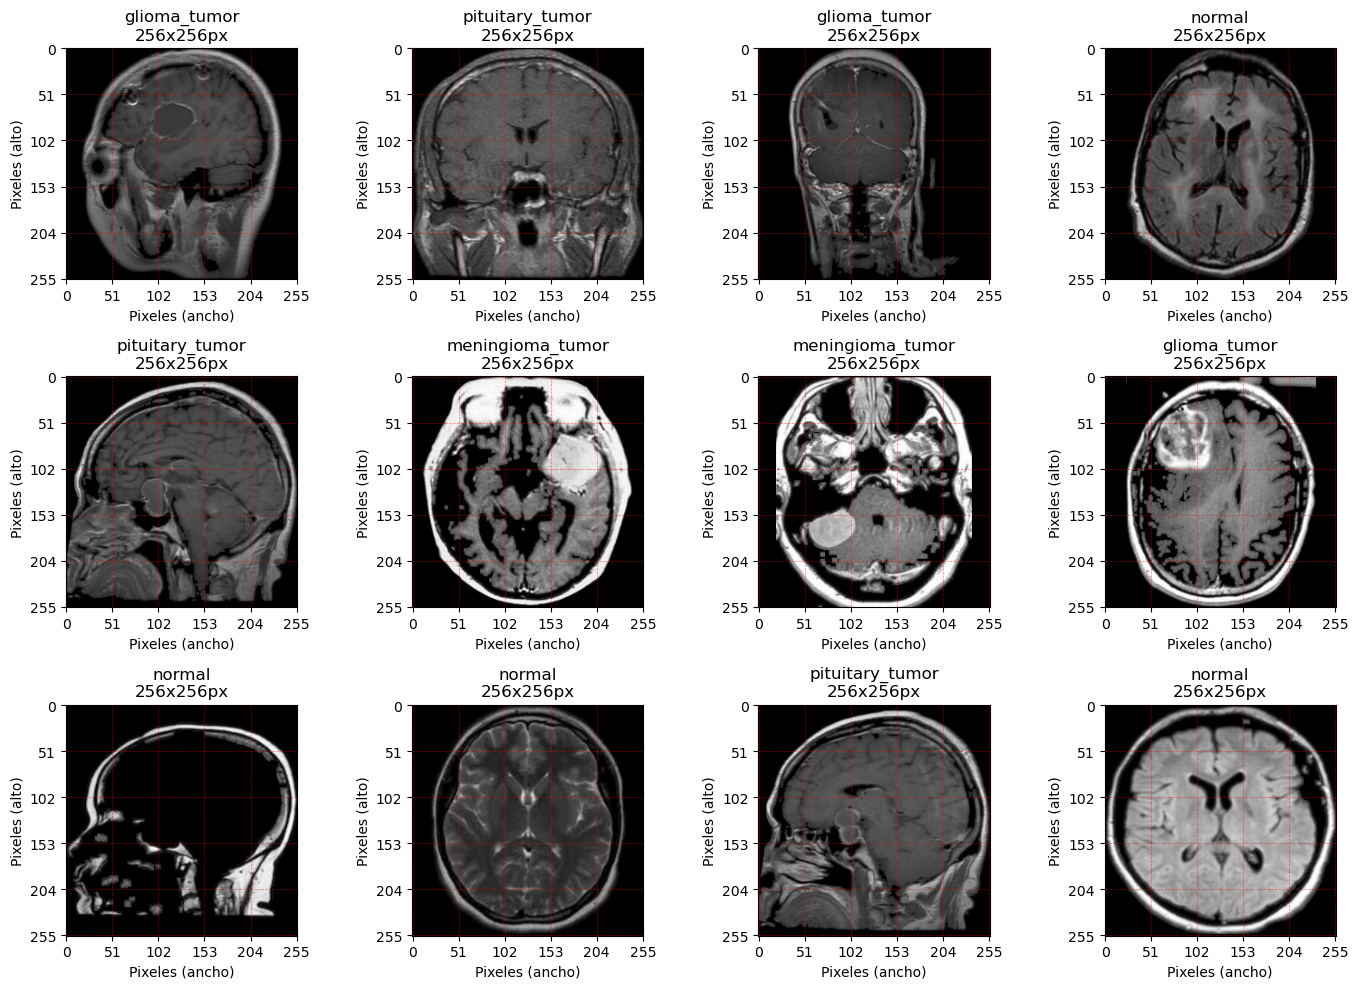

In [5]:
# Recolectar todas las rutas de imágenes y sus etiquetas (nombre de subcarpeta)
imagenes_info = []
for root, dirs, files in os.walk(path):
    if root == path:
        continue
    etiqueta = os.path.basename(root)
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    for img in imagenes:
        imagenes_info.append((os.path.join(root, img), etiqueta))

# Seleccionar 12 imágenes aleatorias
muestras = random.sample(imagenes_info, 12)

# Cargar imágenes y etiquetas
imagenes_cargadas = []
etiquetas = []
for ruta, etiqueta in muestras:
    try:
        img = Image.open(ruta)
        imagenes_cargadas.append(img)
        etiquetas.append(etiqueta)
    except Exception as e:
        print(f"Error cargando {ruta}: {e}")

# Mostrar en una grilla 3x4 con reglas de tamaño (ejes con ticks)
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i < len(imagenes_cargadas):
        img = imagenes_cargadas[i]
        ancho, alto = img.size
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{etiquetas[i]}\n{ancho}x{alto}px")
        # Mostrar ticks cada 50 pixeles (ajusta según tamaño)
        ax.set_xticks(np.arange(0, ancho+1, max(1, ancho//5)))
        ax.set_yticks(np.arange(0, alto+1, max(1, alto//5)))
        ax.set_xlabel('Pixeles (ancho)')
        ax.set_ylabel('Pixeles (alto)')
        ax.grid(True, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

Si elegimos aleatorioamente algunas imágenes, podemos ver que existen tanto diferencias notables entre los cerebros sanos con los enfermos, entre ellas encontramos la variedad de posiciones de tumor, el ángulo de la cabeza, calidad de la imagen MRI y magnificación de la imagen, lo cual nos da un amplio espectro de análisis. 
Aún más importante, podemos notar que todas las imágenes son del mismo tamaño, es decir, $265\times256$. No obstante, es muy luego para afirmar esto.

In [6]:
# Recolectar todas las rutas de imágenes y sus etiquetas (nombre de subcarpeta)
imagenes_info = []
for root, dirs, files in os.walk(path):
    if root == path:
        continue
    etiqueta = os.path.basename(root)
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    for img in imagenes:
        imagenes_info.append((os.path.join(root, img), etiqueta))

# Seleccionar 100 imágenes aleatorias (puedes ajustar el número)
muestras = random.sample(imagenes_info, min(100, len(imagenes_info)))

# Obtener dimensiones de cada imagen seleccionada
dimensiones = []
for ruta, etiqueta in muestras:
    try:
        with Image.open(ruta) as img:
            ancho, alto = img.size
            dimensiones.append({'archivo': ruta, 'etiqueta': etiqueta, 'ancho': ancho, 'alto': alto})
    except Exception as e:
        print(f"Error cargando {ruta}: {e}")

# Crear un DataFrame para resumir
df_dim = pd.DataFrame(dimensiones)

# Mostrar resumen estadístico de las dimensiones
print("Resumen estadístico de dimensiones de imágenes seleccionadas aleatoriamente:")
print(df_dim[['ancho', 'alto']].describe())

Resumen estadístico de dimensiones de imágenes seleccionadas aleatoriamente:
       ancho   alto
count  100.0  100.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0


Ahora, tal como se supuso anteriormente, todas las imágenes presentan un mismo tamaño, lo cual es muy bemeficioso para el análisis. 
Por otro lado, la distribución de píxeles también juega un rol muy importante al momento de implementar modelos de aprendizaje.

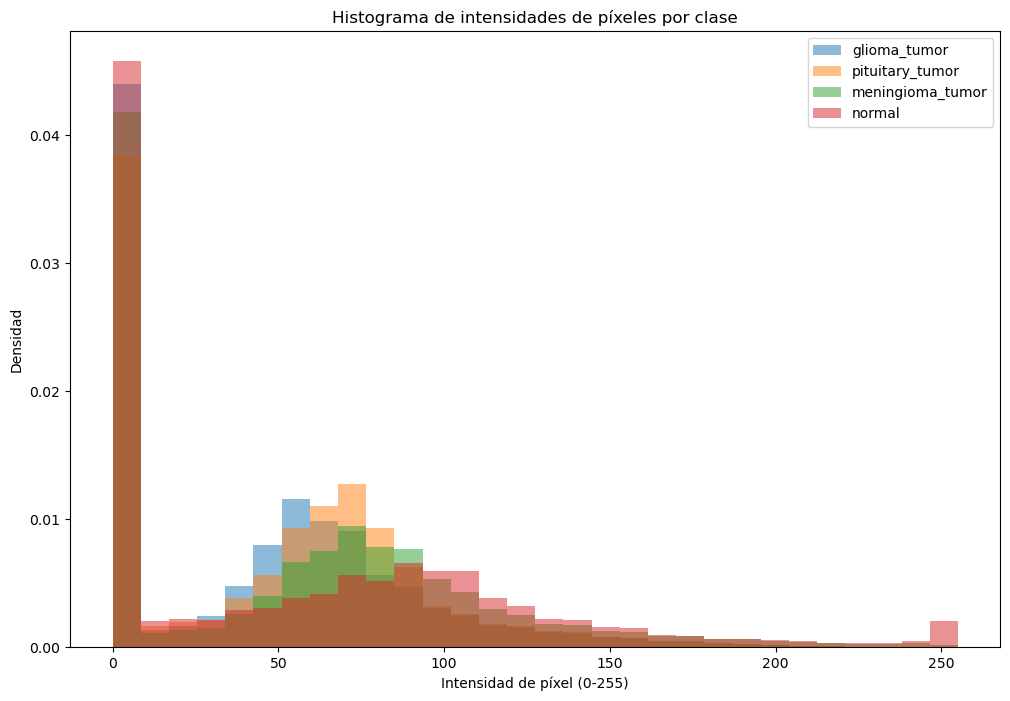

In [7]:
# Histograma de intensidades de píxeles por clase

# Selecciona una cantidad máxima de imágenes por clase para el histograma (por ejemplo, 50)
max_imgs_por_clase = 50
intensidades_por_clase = {}

for clase in set([etq for _, etq in imagenes_info]):
    rutas_clase = [ruta for ruta, etq in imagenes_info if etq == clase]
    muestras_clase = random.sample(rutas_clase, min(max_imgs_por_clase, len(rutas_clase)))
    intensidades = []
    for ruta in muestras_clase:
        try:
            img = Image.open(ruta)
            img_gray = img.convert('L')  # Convertir a escala de grises
            intensidades.extend(np.array(img_gray).flatten())
        except Exception as e:
            print(f"Error cargando {ruta}: {e}")
    intensidades_por_clase[clase] = intensidades

# Graficar histogramas
plt.figure(figsize=(12, 8))
for clase, intensidades in intensidades_por_clase.items():
    plt.hist(intensidades, bins=30, alpha=0.5, label=clase, density=True)
plt.xlabel('Intensidad de píxel (0-255)')
plt.ylabel('Densidad')
plt.title('Histograma de intensidades de píxeles por clase')
plt.legend()
plt.show()

Este histograma nos dice que en las imágenes MRI de un cerebro sano, la proporción de píxeles se concentra alrededor del *gris claro* (**RGB(100, 100, 100)**) , puesto que la masa cerebral sana presenta mayor contraste con el fondo, esto dado que existen circunvoluciones más diferenciadas. 
Por otro lado, los cerebros con tumores relacionados con la *pituitaria* y las células *gliales* presentan una concentración cercana al *gris oscuro* (**RGB(75, 75, 75)**).

Esto nos indica que, al momento de implentar un modelo de clasificación, deberemos centrarnos en determinar la posición aproximada del tumor dependiendo del tipo, un ejemplo de esto, podria se la determinación de los tumores relacionados con la *meninge*, los cuáles se ubican en una zona de alto contraste en la imagen como lo es el extremo de la cabeza y el fondo oscuro.

In [8]:
imagenes_corruptas = []
hashes = {}
imagenes_duplicadas = []

for ruta, etiqueta in imagenes_info:
    try:
        with Image.open(ruta) as img:
            # Intentar cargar la imagen para detectar corrupción
            img.verify()
        # Calcular hash de la imagen para detectar duplicados
        with open(ruta, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in hashes:
            imagenes_duplicadas.append((ruta, hashes[file_hash]))
        else:
            hashes[file_hash] = ruta
    except Exception as e:
        imagenes_corruptas.append(ruta)

print(f"Imágenes corruptas detectadas: {len(imagenes_corruptas)}")
for ruta in imagenes_corruptas:
    print(f"Corrupta: {ruta}")

print(f"\nImágenes duplicadas detectadas: {len(imagenes_duplicadas)}")
for dup, orig in imagenes_duplicadas:
    print(f"Duplicada: {dup} <--> Original: {orig}")

Imágenes corruptas detectadas: 0

Imágenes duplicadas detectadas: 251
Duplicada: ./4 classes\glioma_tumor\G_335.jpg <--> Original: ./4 classes\glioma_tumor\G_330.jpg
Duplicada: ./4 classes\glioma_tumor\G_357.jpg <--> Original: ./4 classes\glioma_tumor\G_333.jpg
Duplicada: ./4 classes\glioma_tumor\G_412.jpg <--> Original: ./4 classes\glioma_tumor\G_227.jpg
Duplicada: ./4 classes\glioma_tumor\G_528.jpg <--> Original: ./4 classes\glioma_tumor\G_423.jpg
Duplicada: ./4 classes\glioma_tumor\G_545.jpg <--> Original: ./4 classes\glioma_tumor\G_143.jpg
Duplicada: ./4 classes\glioma_tumor\G_577.jpg <--> Original: ./4 classes\glioma_tumor\G_434.jpg
Duplicada: ./4 classes\glioma_tumor\G_613.jpg <--> Original: ./4 classes\glioma_tumor\G_368.jpg
Duplicada: ./4 classes\glioma_tumor\G_614.jpg <--> Original: ./4 classes\glioma_tumor\G_379.jpg
Duplicada: ./4 classes\glioma_tumor\G_677.jpg <--> Original: ./4 classes\glioma_tumor\G_523.jpg
Duplicada: ./4 classes\glioma_tumor\G_688.jpg <--> Original: ./4 c

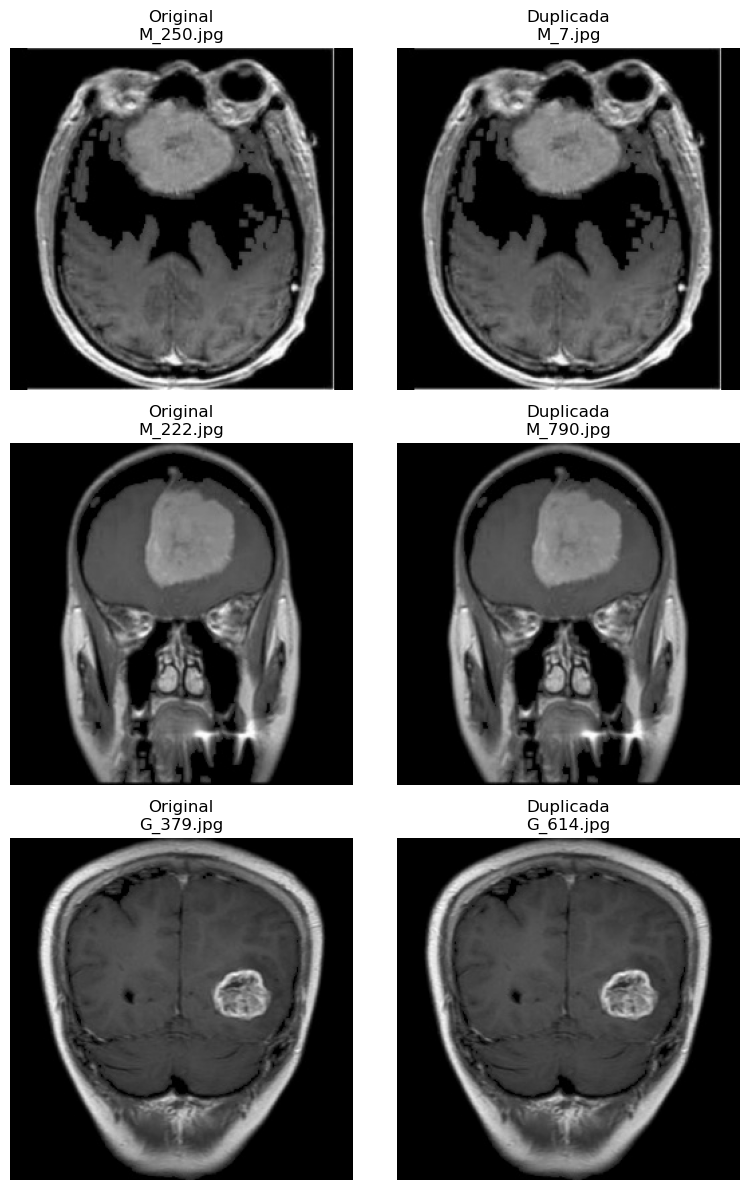

In [9]:
# Visualizar 3 imágenes duplicadas junto con su imagen original
if len(imagenes_duplicadas) >= 3:
    muestras_duplicadas = random.sample(imagenes_duplicadas, 3)
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    for i, (dup_path, orig_path) in enumerate(muestras_duplicadas):
        try:
            img_dup = Image.open(dup_path)
            img_orig = Image.open(orig_path)
            axes[i, 0].imshow(img_orig, cmap='gray')
            axes[i, 0].set_title(f"Original\n{os.path.basename(orig_path)}")
            axes[i, 1].imshow(img_dup, cmap='gray')
            axes[i, 1].set_title(f"Duplicada\n{os.path.basename(dup_path)}")
            for ax in axes[i]:
                ax.axis('off')
        except Exception as e:
            print(f"Error mostrando imágenes: {e}")
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes imágenes duplicadas para mostrar.")

De esto, obtenemos que no existen imágenes corruptas lo que nos simplifica la vida. Sin embargo, existe una proporción mínima de imágenes duplicadas, lo que puede indicar que esto es un error de tipeo al registrar las representaciones o al almacenar los datos. Descartamos un procedimiento de Data Augmentation, debido a que, estas imágenes no presentan rotaciones visibles.

# 2. Limpieza 

De lo señalado con anterioridad, hemos encontrado imágenes duplicadas y por ende la limpieza consistirá en eliminar dichas representaciones.

In [10]:
# Eliminar imágenes duplicadas, conservando solo una copia de cada una

eliminadas = []
for dup_path, orig_path in imagenes_duplicadas:
    try:
        os.remove(dup_path)
        eliminadas.append(dup_path)
        print(f"Eliminada: {dup_path}")
    except Exception as e:
        print(f"Error eliminando {dup_path}: {e}")

print(f"\nTotal de imágenes duplicadas eliminadas: {len(eliminadas)}")

Eliminada: ./4 classes\glioma_tumor\G_335.jpg
Eliminada: ./4 classes\glioma_tumor\G_357.jpg
Eliminada: ./4 classes\glioma_tumor\G_412.jpg
Eliminada: ./4 classes\glioma_tumor\G_528.jpg
Eliminada: ./4 classes\glioma_tumor\G_545.jpg
Eliminada: ./4 classes\glioma_tumor\G_577.jpg
Eliminada: ./4 classes\glioma_tumor\G_613.jpg
Eliminada: ./4 classes\glioma_tumor\G_614.jpg
Eliminada: ./4 classes\glioma_tumor\G_677.jpg
Eliminada: ./4 classes\glioma_tumor\G_688.jpg
Eliminada: ./4 classes\glioma_tumor\G_774.jpg
Eliminada: ./4 classes\glioma_tumor\G_776.jpg
Eliminada: ./4 classes\glioma_tumor\G_780.jpg
Eliminada: ./4 classes\glioma_tumor\G_808.jpg
Eliminada: ./4 classes\glioma_tumor\G_820.jpg
Eliminada: ./4 classes\glioma_tumor\G_859.jpg
Eliminada: ./4 classes\meningioma_tumor\M_143.jpg
Eliminada: ./4 classes\meningioma_tumor\M_144.jpg
Eliminada: ./4 classes\meningioma_tumor\M_157.jpg
Eliminada: ./4 classes\meningioma_tumor\M_159.jpg
Eliminada: ./4 classes\meningioma_tumor\M_161.jpg
Eliminada: ./4

In [11]:
# Obtener la lista de imágenes únicas (sin duplicados)

imagenes_unicas = set()
for ruta, etiqueta in imagenes_info:
    if not any(ruta == dup for dup, _ in imagenes_duplicadas):
        imagenes_unicas.add((ruta, etiqueta))
    # Si la imagen es original (no duplicada), también la agregamos
    for _, orig in imagenes_duplicadas:
        if ruta == orig:
            imagenes_unicas.add((ruta, etiqueta))

imagenes_unicas = list(imagenes_unicas)
print(f"Total de imágenes únicas (sin duplicados): {len(imagenes_unicas)}")

Total de imágenes únicas (sin duplicados): 2845


In [12]:
# Obtener solo las etiquetas de las imágenes únicas
clases = [etiqueta for _, etiqueta in imagenes_unicas]

# Contar imágenes por clase
conteo_clases = Counter(clases)

print("Total de imágenes por clase (sin duplicados):")
for clase, cantidad in conteo_clases.items():
    print(f"{clase}: {cantidad}")

Total de imágenes por clase (sin duplicados):
meningioma_tumor: 816
pituitary_tumor: 834
glioma_tumor: 885
normal: 310


Ahora bien, podemos notar lo siguiente:
| Clase      | Imágenes originales | Imágenes sin duplicado | Imágenes eliminadas |
| ---------- | ------------------- | ---------------------- | ------------------- |
| Glioma     | 901                 | 885                    | 16                  |
| Pituitary  | 844                 | 834                    | 10                  |
| Meningioma | 913                 | 816                    | 97                  |
| Normal     | 438                 | 310                    | 128                 |


# 3. Preprocesamiento

Estudiaremos por separado cada procesamiento dependiendo del modelo.
Para el caso de CNN podemos notar que cada imagen es de 256x256 píxeles y trabajaremos con sus tamaño original, también normalizaremos los datos, los aumentaremos de ser necesarios, y en caso de hacerlo, rotaremos las imágenes para aumentar la cantidad de representaciones. 
En cuanto a Random Forest redimensionaremos la matriz para que sea más sencillo de trabajar, las normalizaremos y extraeremos sus características.

## 3.1 Modelo CNN

Consideramos que la cantidad de imágenes es particularmente pequeña para el entrenamiento que queremos realizarle al modelo, es por ello que haremos un *Data Augmentation*

In [77]:
# Altura y ancho deseado para las imágenes
target_size_CNN = (256, 256)
# Tamaño de "batch" para el entrenamiento del modelo
batch_size = 32

In [78]:
# Generador de imágenes con data augmentation y validación
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.25,              
    validation_split=0.2,         
    fill_mode='nearest'             
)


Expliquemos que hay detrás de las líneas de coódigo previas.
Primero reescalamos las imágenes en $[0,1]$, de esto se encarga el rescale. Luego el zoom_range permite que las imágenes puedan ampliarse o reducirse en un 25%; en cuanto al validation_split considera un $20\%$ como datos de validación. Por último, *nearest* permite rellenar los valores faltantes con el píxel más cercano.

In [81]:
# Generador de imágenes de entrenamiento
seed = 100

train_image_array_gen = train_data_gen.flow_from_directory(
    directory=path,
    target_size =target_size_CNN,
    color_mode='grayscale',             
    batch_size=batch_size,
    seed=seed,
    subset='training',            
    class_mode='categorical'           
)


Found 2277 images belonging to 4 classes.


In [82]:
#Dataset validación
seed = 100

valid_image_array_gen = train_data_gen.flow_from_directory(
    directory=path,
    target_size=target_size_CNN,
    color_mode='grayscale',             
    batch_size=batch_size,
    seed=seed,
    subset='validation',            
    class_mode='categorical'           
)

Found 568 images belonging to 4 classes.


Ahora bien, lo que realizamos de forma previa fue el entrenamiento y validación de los datos, en donde lo importante del código es que utilizaremos escala de grises y usamos una semilla aleatoria. Además la clase es binaria, es decir, de ceros y unos. 
Y de hecho, también podemos notar que el total de datos entre el entrenamiento y validación es de 2845, y por lo tanto, no está usando imágenes duplicadas.

Ahora bien, haremos un Balanceo de datos, para saber si tenemos una proporción adecuada.

In [84]:
seed = 100

#Nro de muestras de entrenamiento y validación
train_samples = train_image_array_gen.samples
valid_samples = valid_image_array_gen.samples

# Numero de clases
output_n = train_image_array_gen.num_classes

# Obtener la proporción de clases en los datos de entrenamiento
clase_counts = Counter(train_image_array_gen.classes)
total = sum(clase_counts.values())

# Mostrar proporciones por clase
print("\nFrecuencia relativa de clases:")
for clase, count in clase_counts.items():
    print(f"Clase {clase}: {count} muestras ({count/total:.2%})")



Frecuencia relativa de clases:
Clase 0: 708 muestras (31.09%)
Clase 1: 653 muestras (28.68%)
Clase 2: 248 muestras (10.89%)
Clase 3: 668 muestras (29.34%)


¿Cómo interpretamos lo anterior?
Recordemos que tenemos 4 clases de tumores, por ende cada una corresponde a *Glioma, Meningioma, Normal y Pituitary*.
Ahora bien, podemos notar que los valores no son particularmente proporcionados, es decir, no trabajamos con $25\%$ para cada clase, sin embargo, esto puede ser un trabajo interesante de ser analizado y por ende no haremos grandes cambios.

## 3.2 Modelo Random Forest

In [72]:
# Redimensionar y normalizar las imágenes para que sean más sencillas de trabajar

# Recordemos que las imágenes tienen un tamaño de 256x256 píxeles, por ende, las vamos a redimensionar a 64x64 píxeles.
target_size_RF = (64, 64)
ruta_base = './4 classes'

# Lista para datos de imágenes y etiquetas
X = []
y = []
clases = sorted(os.listdir(ruta_base))

# Iterar sobre cada clase y cargar las imágenes
for clase in clases:
    ruta_clase = os.path.join(ruta_base, clase)
    if os.path.isdir(ruta_clase):
        for archivo in os.listdir(ruta_clase):
            if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                ruta_imagen = os.path.join(ruta_clase, archivo)
                try:
                    img = load_img(ruta_imagen, target_size=target_size_RF, color_mode='grayscale')
                    img_array = img_to_array(img)/ 255  # Normalizar a [0,1]
                    X.append(img_array)
                    y.append(clases.index(clase))  # Usar el índice de la clase como etiqueta
                except Exception as e:
                    print(f"Error cargando {ruta_imagen}: {e}") 


# Convertir a numpy arrays
X = np.array(X)
y = np.array(y) 

print("Tamaño de X:", X.shape)  # (n_imagenes, 64, 64, 1)
print("Tamaño de y:", y.shape)  # (n_imagenes,)

Tamaño de X: (2845, 64, 64, 1)
Tamaño de y: (2845,)


Lo anterior nos indica el tamaño de los vectores, en donde 2845 indica las imagenes totales, y su redimension en 64x64x1, donde el 1 indica las respresentaciones en escala de grises.

In [ ]:
# Extraer características de las imágenes

# Aplanar las imágenes para que cada imagen sea un vector de características
X_flat = X.reshape(X.shape[0], -1)  # (n_imagenes, 64*64*1)

print("Tamaño de X_flat:", X_flat.shape)  # (n_imagenes, 64*64*1)

Tamaño de X_flat: (2845, 4096)


Ahora bien, lo anterior nos permite ver el número de imágenes y el resultado al multiplicar $64*64*1$

# 4. Implementación del Modelo

## 4.1 Modelo de CNN

In [85]:
# Parámetros
input_shape_CNN = (256, 256, 1) 
n_clases = 4                 

In [88]:
# Definición del modelo
capas = Sequential([
        Conv2D(16, (3, 3), 
        activation='relu', 
        padding='same',
        input_shape=input_shape_CNN),

        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(32, (3, 3), 
        activation='relu',
        padding='same'),

        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), 
        activation='relu',
        padding='same'),

        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_clases, activation='softmax')
])

print(capas.summary())


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 64)     

In [92]:
modelo = keras.Sequential(layers=capas)

modelo.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        'accuracy',
    ]
)

print('Resumen del modelo:')
print(modelo.summary())



Resumen del modelo:
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 4)                 8412548   
                                                                 
Total params: 8,412,548
Trainable params: 8,412,548
Non-trainable params: 0
_________________________________________________________________
None


Ahora bien podemos notar lo siguiente:
| Capa                  | Operación              | Entrada → Salida            | Detalles                                                               |
| --------------------- | ---------------------- | --------------------------- | ---------------------------------------------------------------------- |
| **Conv2D(16, 3x3)**   | convolución con `same` | (256×256×1) → (256×256×16)  | Padding ‘same’ conserva tamaño. Hay 16 filtros.                        |
| **MaxPooling2D(2x2)** | pooling                | (256×256×16) → (128×128×16) | Reduce a la mitad cada dimensión.                                      |
| **Conv2D(32, 3x3)**   | convolución con `same` | (128×128×16) → (128×128×32) | 32 filtros, mismo padding.                                             |
| **MaxPooling2D(2x2)** | pooling                | (128×128×32) → (64×64×32)   | Mitad de tamaño.                                                       |
| **Conv2D(64, 3x3)**   | convolución con `same` | (64×64×32) → (64×64×64)     | 64 filtros.                                                            |
| **MaxPooling2D(2x2)** | pooling                | (64×64×64) → (32×32×64)     | Nuevamente reducción.                                                  |
| **Flatten**           | aplana                 | (32×32×64) → 65536          | 32×32×64 = 65536 neuronas en la capa totalmente conectada.             |
| **Dense(128)**        | capa densa             | 65536 → 128                 | Conecta todas las neuronas anteriores a 128 nuevas.                    |
| **Dropout(0.5)**      | regularización         | 128 → 128                   | Previene overfitting.                                                  |
| **Dense(4)**          | capa de salida         | 128 → 4                     | Una neurona por clase, con softmax (activación definida en tu modelo). |


Y por último se nos permite notar el total de parámetros de nuestro modelo que es de $8,412,548$

Ahora bien, nuestra siguiente etapa consiste en la ejecución del modelo.

In [93]:
# Callbacks
os.makedirs('modelos', exist_ok=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='modelos/modelo.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

In [94]:
# Entrenamiento
n_epocas = 20
print('🔴 Iniciando entrenamiento del modelo...')

historial = modelo.fit(
    train_image_array_gen,
    epochs=n_epocas,
    validation_data=valid_image_array_gen,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print('✅ Entrenamiento finalizado.')

🔴 Iniciando entrenamiento del modelo...
Epoch 1/20
72/72 [==============================] - 20s 269ms/step - loss: 1.3336 - accuracy: 0.3448 - val_loss: 1.3220 - val_accuracy: 0.3521
Epoch 2/20
72/72 [==============================] - 19s 263ms/step - loss: 1.2746 - accuracy: 0.4040 - val_loss: 1.2231 - val_accuracy: 0.4454
Epoch 3/20
72/72 [==============================] - 19s 266ms/step - loss: 1.1731 - accuracy: 0.4840 - val_loss: 1.1678 - val_accuracy: 0.4754
Epoch 4/20
72/72 [==============================] - 19s 267ms/step - loss: 1.0901 - accuracy: 0.5217 - val_loss: 1.0996 - val_accuracy: 0.5335
Epoch 5/20
72/72 [==============================] - 19s 264ms/step - loss: 1.0037 - accuracy: 0.5819 - val_loss: 1.0132 - val_accuracy: 0.5933
Epoch 6/20
72/72 [==============================] - 19s 261ms/step - loss: 0.9654 - accuracy: 0.5894 - val_loss: 1.0309 - val_accuracy: 0.5704
Epoch 7/20
72/72 [==============================] - 19s 266ms/step - loss: 0.9191 - accuracy: 0.6157 -

 Historial:
        loss  accuracy  val_loss  val_accuracy
0   1.333556  0.344752  1.322050      0.352113
1   1.274557  0.404040  1.223106      0.445423
2   1.173129  0.483970  1.167797      0.475352
3   1.090063  0.521739  1.099570      0.533451
4   1.003748  0.581906  1.013196      0.593310
5   0.965374  0.589372  1.030941      0.570423
6   0.919078  0.615722  0.908979      0.623239
7   0.884354  0.627580  0.891776      0.633803
8   0.851263  0.645147  0.885237      0.621479
9   0.820041  0.673254  0.849359      0.633803
10  0.814686  0.667984  0.934691      0.600352
11  0.778681  0.687747  0.856289      0.653169
12  0.757918  0.696970  0.864787      0.637324
13  0.748784  0.693895  0.882564      0.632042
14  0.744880  0.697848  0.827554      0.656690
15  0.741370  0.702240  0.817858      0.651408
16  0.680573  0.735617  0.796006      0.665493
17  0.685093  0.729029  0.839775      0.649648
18  0.678331  0.725516  0.811234      0.674296
19  0.642176  0.760650  0.793831      0.672535
 

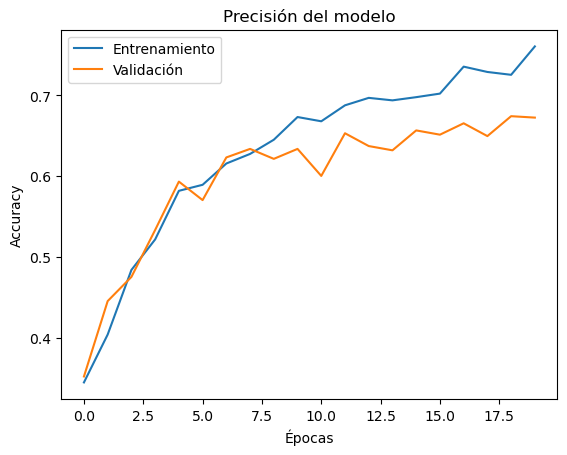

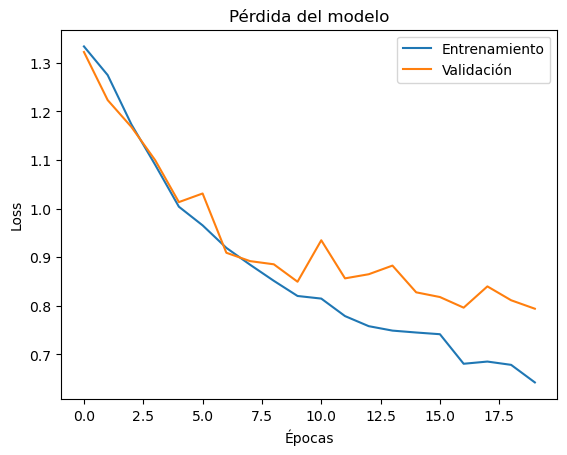

In [100]:
# Predicción de las clases
print(' Historial:')
print(pd.DataFrame(historial.history))
print(' Graficando historial...')

# Accuracy
plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 4.2 Modelo de Random Forest

# 5. Visualización de Resultados

# 5.1 Modelo de CNN

Acá vamos a estudiar diferentes métricas para comprender como funciona el modelo y con ello llegar a una interpretración y conclusión del modelo.

In [101]:
# Obtener predicciones del modelo sobre el set de validación
y_pred_proba = modelo.predict(valid_image_array_gen)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = valid_image_array_gen.classes

18/18 [==============================] - 4s 226ms/step


In [102]:
# Reporte detallado por clase
print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=valid_image_array_gen.class_indices.keys()))

📊 Reporte de clasificación:
                  precision    recall  f1-score   support

    glioma_tumor       0.36      0.31      0.34       177
meningioma_tumor       0.31      0.23      0.26       163
          normal       0.16      0.29      0.20        62
 pituitary_tumor       0.30      0.33      0.32       166

        accuracy                           0.29       568
       macro avg       0.28      0.29      0.28       568
    weighted avg       0.31      0.29      0.29       568



In [105]:
# Binarizar etiquetas verdaderas (One-hot)
y_true_bin = label_binarize(y_true, classes=range(n_clases))

# ROC AUC One-vs-Rest
roc_auc_macro = roc_auc_score(y_true_bin, y_pred_proba, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')

print(f"🔵 ROC AUC (macro): {roc_auc_macro:.4f}")
print(f"🟠 ROC AUC (weighted): {roc_auc_weighted:.4f}")

🔵 ROC AUC (macro): 0.5218
🟠 ROC AUC (weighted): 0.5240


c:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


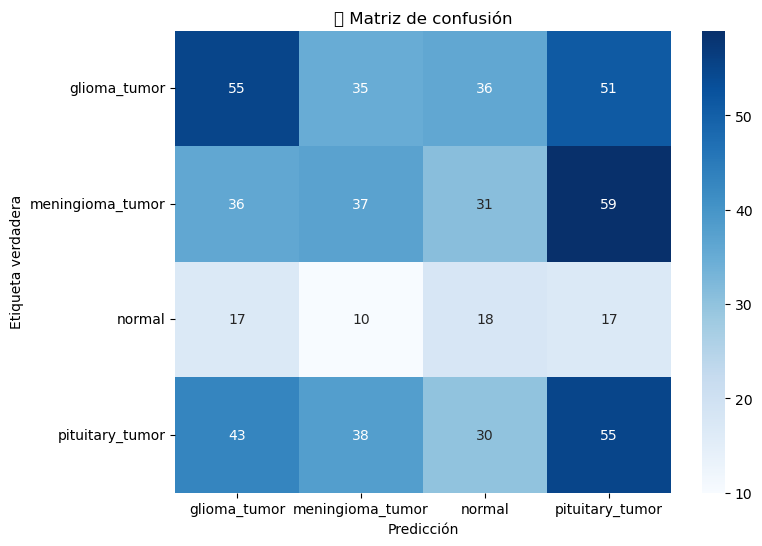

In [106]:
cm = confusion_matrix(y_true, y_pred)
labels = list(valid_image_array_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('🔎 Matriz de confusión')
plt.show()